In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch as th
import torch.nn as nn
import numpy as np
# from numpy import linalg as la
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
import seaborn as sns
import tikzplotlib as tikz
from scipy import ndimage

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *

# standard datatype
dtype = th.double

In [2]:
# set path to models and initialise arrays
model_path = '../storage/models/kaandorp_data/ph_cdc_sd/additional_features/fs1_fs2_fs3'
model = th.load(os.sep.join([model_path, 'model.pt']))
mu = th.load(os.sep.join([model_path, 'mu.th']))
std = th.load(os.sep.join([model_path, 'std.th']))
_ = model.eval()  # mandatory, see torch.load doc

In [38]:
# read in tensor data
rans_path = '/home/leonriccius/Desktop/PeriodicHills/Re2800/Re2800_kOmega_150_dd_corr_inv'
# pred_path = '/home/leonriccius/Documents/Fluid_Data/rans_kaandorp/PeriodicHills/Re5600_kOmega_150/'

rans_time = max([int(entry) for entry in os.listdir(rans_path) if entry.isnumeric()])
rans_time = '30000'

u = pre.readVectorData(rans_time, 'U', rans_path)
grid = pre.readCellCenters(rans_time, rans_path)
rs = pre.readSymTensorData(rans_time, 'turbulenceProperties:R', rans_path).reshape(-1, 3, 3)
grad_u = pre.readTensorData(rans_time, 'grad(U)', rans_path)
grad_k = pre.readVectorData(rans_time, 'grad(k)', rans_path)
grad_p = pre.readVectorData(rans_time, 'grad(p)', rans_path)
y_wall = pre.readScalarData(rans_time, 'yWall', rans_path)
k = pre.readScalarData(rans_time, 'k', rans_path)
omega = pre.readScalarData(rans_time, 'omega', rans_path)  # 'epsilon' or 'omega'
epsilon = omega * k * 0.09  # 0.09 is beta star
nu = 3.5714285714285714e-04

# get b_rans
b_rans = barymap.anisotropy(rs, k)

# calculate mean rate of strain and rotation tensors
s = 0.5 * (grad_u + grad_u.transpose(1, 2))
r = 0.5 * (grad_u - grad_u.transpose(1, 2))

# normalize s and r
s_hat = (k / epsilon).unsqueeze(1).unsqueeze(2) * s
r_hat = (k / epsilon).unsqueeze(1).unsqueeze(2) * r
grad_k_hat = (th.sqrt(k) / epsilon).unsqueeze(1) * grad_k

# capping tensors
s_hat = cap_tensor(s_hat, 6.0)
r_hat = cap_tensor(r_hat, 6.0)

# get invariants and remove features
inv_fs1 = get_invariants(s_hat, r_hat)
for i in [3,4][::-1]:  # must be in reverse of indices are wrong
    inv_fs1 = th.cat((inv_fs1[:, :i - 1], inv_fs1[:, i:]), dim=1)

inv_fs2 = get_invariants_fs2(s_hat, r_hat, grad_k_hat)
for i in [4, 5, 6, 7, 8, 10, 11, 12][::-1]:  # must be in reverse of indices are wrong
    inv_fs2 = th.cat((inv_fs2[:, :i - 1], inv_fs2[:, i:]), dim=1)

inv_fs3 = get_invariants_fs3(s, r, rs, u, grad_u, grad_p, grad_k, k, epsilon, y_wall, nu)

inv = th.cat((inv_fs1, inv_fs2, inv_fs3), dim=1)

# scale invariants
inv_mean_std = mean_std_scaling(inv, mu=mu, std=std)[0]

t = get_tensor_functions(s_hat, r_hat)
t_zero_trace = enforce_zero_trace(t.reshape(-1,10,3,3))
b_pred,_ = model(inv_mean_std, t_zero_trace.reshape(-1,10,9))
b_pred = b_pred.reshape(-1,3,3).detach()



# dns data
path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata_unscaled_inv_corr/PeriodicHills/2800'
b_dns = th.load(os.sep.join([path_dns, 'b_dns-torch.th']))
# grid_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))

Attempting to read file: /home/leonriccius/Desktop/PeriodicHills/Re2800/Re2800_kOmega_150_dd_corr_inv/30000/U
Parsing file...
Data field file successfully read.
Reading mesh cell centers /home/leonriccius/Desktop/PeriodicHills/Re2800/Re2800_kOmega_150_dd_corr_inv/30000/cellCenters
Attempting to read file: /home/leonriccius/Desktop/PeriodicHills/Re2800/Re2800_kOmega_150_dd_corr_inv/30000/turbulenceProperties:R
Parsing file...
Data field file successfully read.
Attempting to read file: /home/leonriccius/Desktop/PeriodicHills/Re2800/Re2800_kOmega_150_dd_corr_inv/30000/grad(U)
Parsing file...
Data field file successfully read.
Attempting to read file: /home/leonriccius/Desktop/PeriodicHills/Re2800/Re2800_kOmega_150_dd_corr_inv/30000/grad(k)
Parsing file...
Data field file successfully read.
Attempting to read file: /home/leonriccius/Desktop/PeriodicHills/Re2800/Re2800_kOmega_150_dd_corr_inv/30000/grad(p)
Parsing file...
Data field file successfully read.
Attempting to read file: /home/leon

In [39]:
b_real = b_pred.clone()

for i in range(5):
    b_real = enforce_realizability(b_real)

Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True


In [40]:
print('max b:       {:.4f}'.format(th.max(b_pred[:,0,0])))
print('max b_real:  {:.4f}'.format(th.max(b_real[:,0,0])))

max b:       0.5363
max b_real:  0.5363


In [41]:
# filter b_pred
nx, ny = 140, 150
b_real_reshaped = b_real.reshape(ny,nx,3,3).permute(2,3,0,1).detach().numpy()
b_real_filt = th.from_numpy(filterField(b_real_reshaped, std=2)).reshape(3,3,-1).permute(2,0,1)

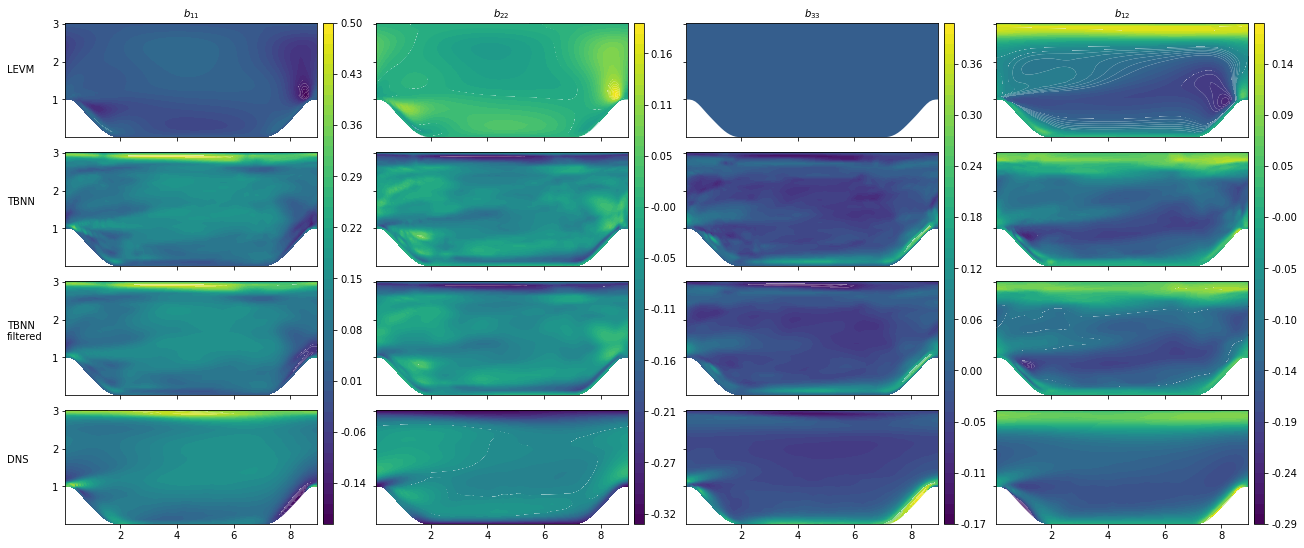

In [51]:
# define refinement level of interpolation grid and how much of boundary should be but off
ref = 10
gamma = 0.995

# find min an max of x coordinate
x_min, x_max = np.min(grid[:,0].numpy()), np.max(grid[:,0].numpy())
x_mean = 0.5*(x_max - x_min)
x_min = x_mean - gamma*(x_mean - x_min)
x_max = x_mean - gamma*(x_mean - x_max)

# find min an max of y coordinate
y_min, y_max = np.min(grid[:,1].numpy()), np.max(grid[:,1].numpy())
y_mean = 0.5*(y_max - y_min)
y_min = y_mean - gamma*(y_mean - y_min)
y_max = y_mean - gamma*(y_mean - y_max)

# compute number of points per coordinate
np_x = int(ref*(x_max - x_min))
np_y = int(ref*(y_max - y_min))

# get grid and shift points on curved boundaries
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, np_x), np.linspace(y_min, y_max, np_y))
grid_y_shifted = ph_interp(grid_x)*(y_max - grid_y)/y_max + grid_y
grid_y = grid_y_shifted

# interpolate b tensor
grid_b_rans = griddata(grid[:,0:2], b_rans.numpy(), (grid_x, grid_y), method = 'linear') #, fill_value=0.)
grid_b_pred = griddata(grid[:,0:2], b_pred.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_real = griddata(grid[:,0:2], b_real.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_real_filt = griddata(grid[:,0:2], b_real_filt.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_dns = griddata(grid[:,0:2], b_dns.numpy(), (grid_x, grid_y), method = 'linear')

# get min an max of (b_pred, b_test) for colormap
tmp = np.vstack((grid_b_rans, grid_b_real, grid_b_dns))
b_min = np.min(tmp, axis=(0,1))
b_max = np.max(tmp, axis=(0,1))

components = [[0,0], [1,1], [2,2], [0,1]]
ncols = len(components)
nrows = 4
s = 1.5

# # create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*3.*ncols, s*1.25*nrows), sharex=True, sharey=True,
                       constrained_layout=True)   # set factor for ncols to 4.5 for true scaling of physical domain


for i, cmp in enumerate(components):
    
    levels = np.linspace(b_min[cmp[0], cmp[1]], b_max[cmp[0], cmp[1]], 50)

    b_rans_plot = ax[0,i].contourf(grid_x, grid_y_shifted, grid_b_rans[:,:,cmp[0],cmp[1]], levels = levels)
    b_pred_plot = ax[1,i].contourf(grid_x, grid_y_shifted, grid_b_pred[:,:,cmp[0],cmp[1]], levels = levels)
#     b_pred_filt_plot = ax[2,i].contourf(grid_x, grid_y_shifted, grid_b_pred_filt[:,:,cmp[0],cmp[1]], levels = levels)
#     b_real_plot = ax[2,i].contourf(grid_x, grid_y_shifted, grid_b_real[:,:,cmp[0],cmp[1]], levels = levels)
    b_real_filt_plot = ax[2,i].contourf(grid_x, grid_y_shifted, grid_b_real_filt[:,:,cmp[0],cmp[1]], levels = levels)
    b_dns_plot = ax[3,i].contourf(grid_x, grid_y_shifted, grid_b_dns[:,:,cmp[0],cmp[1]], levels = levels)
    
        # remove contour lines
    for contour in [b_rans_plot, b_pred_plot, b_real_filt_plot, b_dns_plot]:
        for c in contour.collections:
            c.set_edgecolor("face")
            c.set_linewidth(0.00000000000000001)
    
    fig.colorbar(b_dns_plot, ax=ax[:,i].flat, aspect=7.5*ncols*nrows, format='%.2f', pad=0.0)

ax[0,0].set_title(r'$b_{11}$', fontsize='medium')
ax[0,1].set_title(r'$b_{22}$', fontsize='medium')
ax[0,2].set_title(r'$b_{33}$', fontsize='medium')
ax[0,3].set_title(r'$b_{12}$', fontsize='medium')

x_off = -2.0
y_off = 1.7

ax[0,0].text(x_off,y_off, r'LEVM', fontsize='medium', ha='left')
ax[1,0].text(x_off,y_off, r'TBNN', fontsize='medium', ha='left', va='center')
ax[2,0].text(x_off,y_off, r'TBNN' '\n' r'filtered', fontsize='medium', ha='left', va='center')
ax[3,0].text(x_off,y_off, r'DNS', fontsize='medium', ha='left', va='center')

# save fig
fig_path = '/home/leonriccius/Desktop/'
fig_name =  time() + '_real_loss_1e+00_phill_2800.pdf'
plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

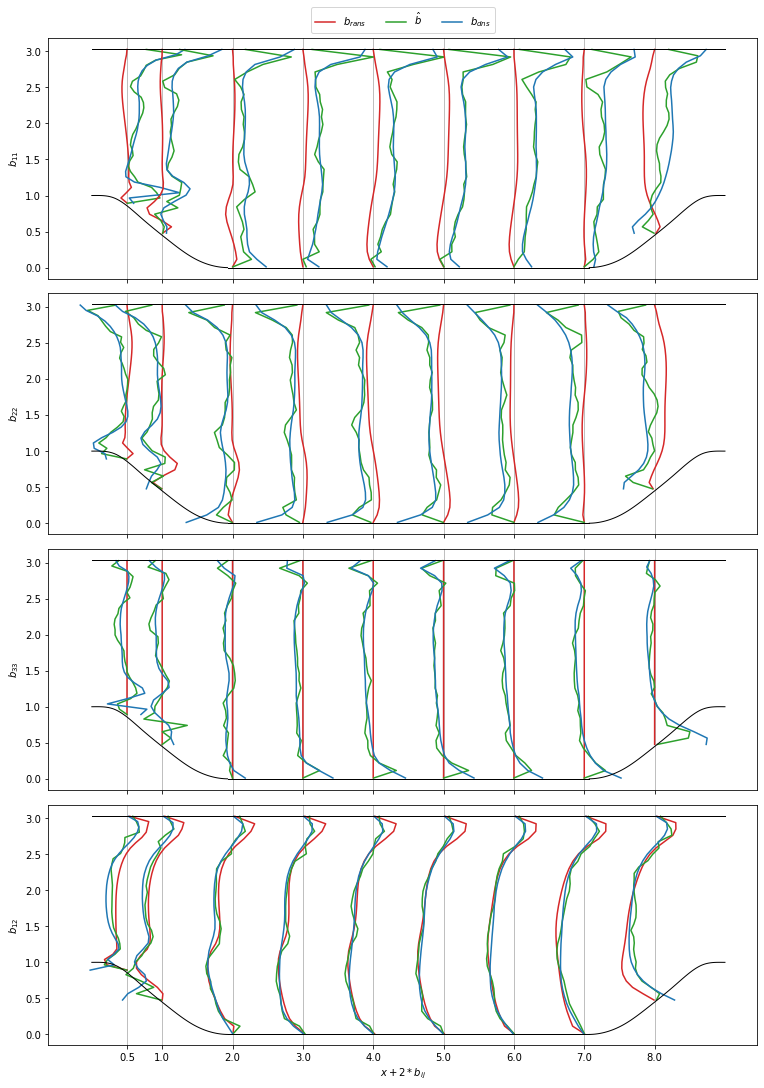

In [44]:
# set path to save figures
# fig_path = '/home/leonriccius/Desktop'

# select x locations to plot
x_data = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
tol = 4e-2

# select components
components = [[0,0],[1,1],[2,2],[0,1]]

# set number of columns to plot
ncols = 1
nrows = len(components)

# create figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5*7*ncols, 1.5*2.5*nrows),
                        sharex=True, sharey=True, constrained_layout=True)
plt.xticks(x_data)

for i, cmp in enumerate(components):
    for j, val in enumerate(x_data):
        # find x location in grid
        x_loc = np.argmin(np.absolute(grid_x[0] - val))
        x_val = grid_x[0, x_loc]

        # create mask and select points in the slice
        grid_slice = grid_y[:, x_loc]
        b_dns_slice = grid_b_dns[:, x_loc, cmp[0], cmp[1]]
        b_rans_slice = grid_b_rans[:, x_loc, cmp[0], cmp[1]]
        b_pred_slice = grid_b_pred[:, x_loc, cmp[0], cmp[1]]

#         # plot all bs for current slice
        axs[i].plot(2*b_rans_slice + val, grid_slice,
                   color=sns.color_palette()[3]) #, label = r'$b_{rans}')
        axs[i].plot(2*b_pred_slice + val, grid_slice,
                   color=sns.color_palette()[2]) #, label = r'$\hat b$')
        axs[i].plot(2*b_dns_slice + val, grid_slice,
                   color=sns.color_palette()[0]) #, label = r'$b_{dns}$')
        axs[i].set_ylabel(r'$b_{'+str(cmp[0]+1)+str(cmp[1]+1)+'}$')
    
    # plot lower and upper wall of hill and grid
    barymap.plot_periodic_hills_boundaries(axs[i])
    axs[i].grid(axis='x')

# plot legend    
axs[0].legend([r'$b_{rans}$', r'$\hat b$', r'$b_{dns}$'], bbox_to_anchor=(0.5, 1.00), loc='lower center', ncol=3)

# plot xlabel
axs[-1].set_xlabel(r'$x + 2*b_{ij}$')

# save figure
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/'
fig_name = time() + '_phill_b_on_slices.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

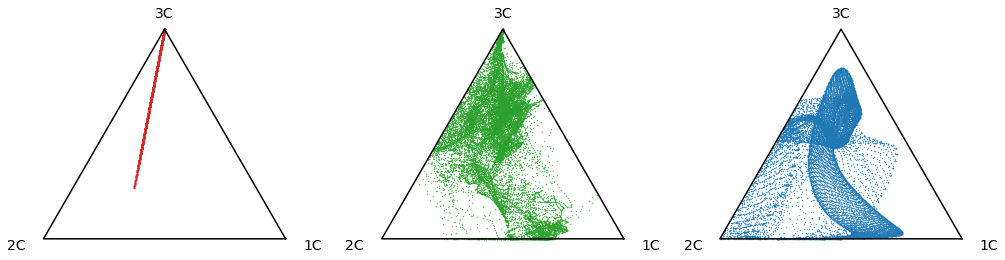

In [55]:
fig, ax = plt.subplots(1,3, figsize=(14,3.5), sharey=True, constrained_layout=True)

ax[0].axis('equal')
ax[0].axis('off')
ax[1].axis('equal')
ax[1].axis('off')
ax[2].axis('equal')
ax[2].axis('off')

barm_rans = BarMap()
# barm_rans.load_from_variable(b_rans[index], grid[index][:,0:2])
barm_rans.load_from_variable(b_rans, grid[:,0:2])
barm_rans.calculate_barycentric_coordinates()
barm_rans.plot_triangle(ax[0])
barm_rans.plot_data_points(ax[0], color=sns.color_palette()[3], s=0.1)

barm_pred = BarMap()
# barm_pred.load_from_variable(b_pred[index].detach().numpy(), grid[index][:,0:2])
barm_pred.load_from_variable(b_real.numpy(), grid[:,0:2])
barm_pred.calculate_barycentric_coordinates()
barm_pred.plot_triangle(ax[1])
barm_pred.plot_data_points(ax[1], color=sns.color_palette()[2], s=0.1)

barm_dns = BarMap()
# barm_dns.load_from_path(path_dns)
barm_dns.load_from_variable(b_dns, grid[:,0:2])
barm_dns.calculate_barycentric_coordinates()
barm_dns.plot_triangle(ax[2])
barm_dns.plot_data_points(ax[2], color=sns.color_palette()[0], s=0.1)

for axs in ax.flat:
        axs.text(1.15, 0.0, '1C', fontsize=14,
            horizontalalignment='right', verticalalignment='top')
        axs.text(-0.15, 0.0, '2C', fontsize=14,
            horizontalalignment='left', verticalalignment='top')
        axs.text(0.50, 0.9, '3C', fontsize=14,
            horizontalalignment='center', verticalalignment='bottom')
        
# save figure
fig_path = '/home/leonriccius/OneDrive/Dokumente/Uni/Masterthesis/abstract'
fig_name = time() + 'barmap_conv.svg'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='svg')

<ipython-input-37-a3bae3e9008d>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


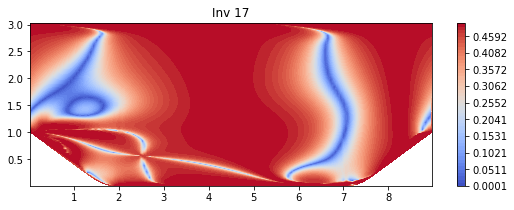

In [37]:
cmap = matplotlib.cm.get_cmap("coolwarm")

i = 16

inv_min = th.min(inv[:, i])
inv_max = th.max(inv[:, i])*1.0001
levels = np.linspace(inv_min, inv_max, 50)
fig, ax = plt.subplots(figsize=(9, 3))
plot = ax.tricontourf(grid[:, 0], grid[:, 1], inv[:, i], cmap=cmap, levels=levels)
ax.set_title('Inv {}'.format(i + 1))
fig.colorbar(plot)
fig.show()